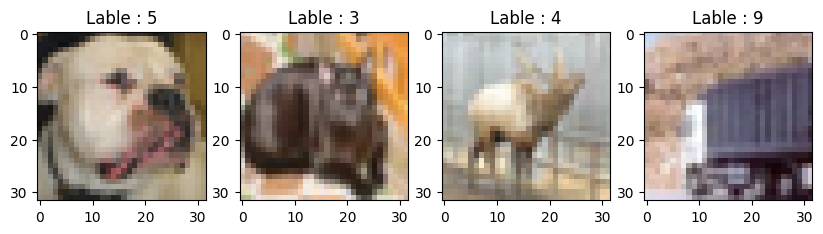

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 

transform = transforms.ToTensor()

train_dataset = torchvision.datasets.CIFAR10(root = './data' , train = True , download = True , transform = transform)
test_dataset = torchvision.datasets.CIFAR10(root = './data' , train = False , download = True , transform = transform)

train_dataloader = torch.utils.data.DataLoader( train_dataset , batch_size=128 , shuffle=True , num_workers=4 , pin_memory=True )
test_dataloader = torch.utils.data.DataLoader(test_dataset , batch_size=128 , shuffle=False , num_workers=4 , pin_memory=True)

data_iterable = iter(train_dataloader)
images , lables = next(data_iterable)

figure , axes = plt.subplots(1 , 4 , figsize = (10,3) )
for i in range(4):
    axes[i].imshow(images[i].permute(1,2,0))
    axes[i].set_title(f"Lable : {lables[i].item()}") 

plt.show()

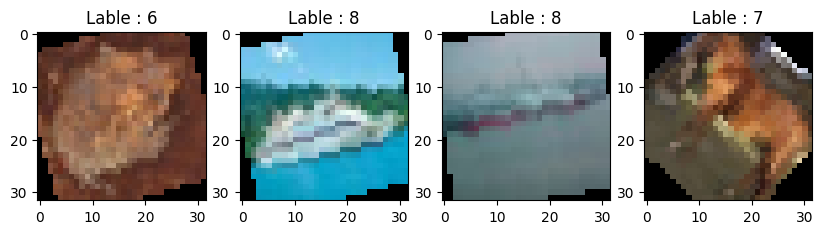

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 


transform_for_aug = transforms.Compose([
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation(45),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5,0.5,0.5) ,(0.5,0.5,0.5)),                                     
                                        ])

transform_for_test = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5,0.5,0.5) ,(0.5,0.5,0.5))
])

train_dataset_with_aug = torchvision.datasets.CIFAR10(root = './data' , train = True , download = True , transform = transform_for_aug)

test_dataset_noaug = torchvision.datasets.CIFAR10(root = './data' , train = True , download = True , transform = transform_for_test)

train_dataloader_with_aug = torch.utils.data.DataLoader( train_dataset_with_aug ,batch_size=128 , shuffle = True , num_workers = 4 , pin_memory=True)
test_dataloader_noaug = torch.utils.data.DataLoader(test_dataset_noaug , batch_size=128 , shuffle = False , num_workers = 4 , pin_memory=True)

data_iterable_with_aug = iter(train_dataloader_with_aug)
images , lables = next(data_iterable_with_aug)

figure , axes = plt.subplots(1 , 4 , figsize = (10,3) )
for i in range(4):
    axes[i].imshow(images[i].permute(1,2,0)*0.5 + 0.5)
    axes[i].set_title(f"Lable : {lables[i].item()}") 

plt.show()


In [3]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self , input_channel : int , hidden_units : int , output_classes :int ):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_channel , out_channels= hidden_units , kernel_size = 3 , stride = 1 , padding = 1 ),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units , out_channels= hidden_units , kernel_size = 3 , stride = 1 , padding = 1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units , out_channels= hidden_units*2 , kernel_size = 3 , stride = 1 , padding = 1 ),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units*2 , out_channels= hidden_units*2 , kernel_size = 3 , stride = 1 , padding = 1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*2*8*8 , 256),
            nn.ReLU(),
            nn.Linear(256 , output_classes)

        )


    def forward(self , x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x




In [4]:
import torch
print(torch.__version__)      
print(torch.version.cuda)      
print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0))  


2.8.0+cu126
12.6
True
NVIDIA GeForce RTX 4050 Laptop GPU


Using Device: cuda
Epoch 1/10 | Loss: 1.6048 | Test Accuracy: 55.14%
Epoch 2/10 | Loss: 1.1763 | Test Accuracy: 61.75%
Epoch 3/10 | Loss: 0.9872 | Test Accuracy: 65.97%
Epoch 4/10 | Loss: 0.8426 | Test Accuracy: 70.29%
Epoch 5/10 | Loss: 0.7171 | Test Accuracy: 71.99%
Epoch 6/10 | Loss: 0.6200 | Test Accuracy: 73.80%
Epoch 7/10 | Loss: 0.5348 | Test Accuracy: 74.39%
Epoch 8/10 | Loss: 0.4492 | Test Accuracy: 74.84%
Epoch 9/10 | Loss: 0.3654 | Test Accuracy: 75.31%
Epoch 10/10 | Loss: 0.2917 | Test Accuracy: 75.13%


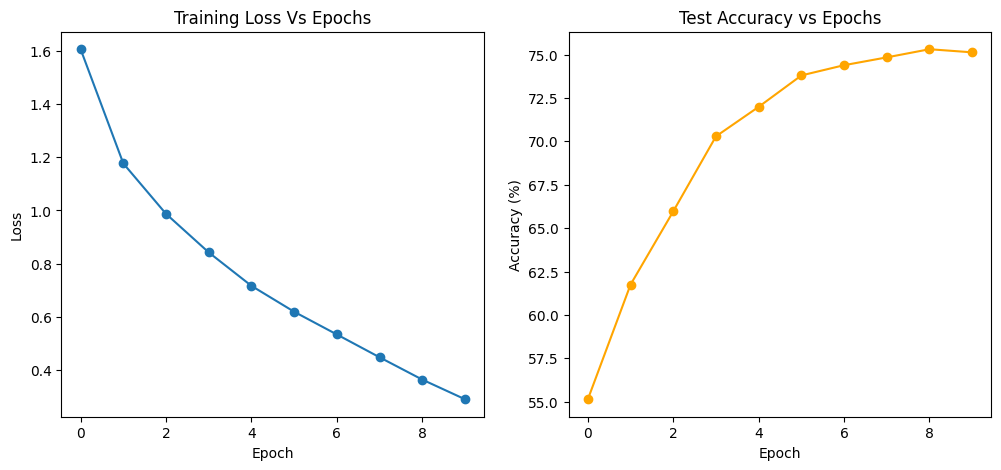

In [ ]:
# No Augmentation Training of CNN model(TinyVgg) From scratch

import matplotlib.pyplot as plt

model = TinyVGG(input_channel=3, hidden_units=32, output_classes=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = "cuda"
    print("Using Device:", device)
else:
    device = "cpu"
    print("Using Device:", device)

model = model.to(device)

epoch = 10
train_losses = []
test_accuracies = []

for i in range(epoch):
    # Training
    model.train()
    running_loss = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = loss_fn(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # Evaluation 
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            vals, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)

    print(f"Epoch {i+1}/{epoch} | Loss: {avg_loss:.4f} | Test Accuracy: {acc:.2f}%")

#  Plot Loss & Accuracy 
plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss Vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(test_accuracies, marker='o', color='orange')
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()



In [6]:
#No Augmentation Testing

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images,lables in test_dataloader:
                                        
        images = images.to(device)
        lables = lables.to(device)

        output = model(images)

        values , predicted_index = torch.max(output , 1)

        total = total + lables.size(0)
        correct = correct + (predicted_index == lables).sum().item()
print(f"Test Accuracy (without augmentation): {100 * correct / total:.2f}%")

Test Accuracy (without augmentation): 75.13%


Using Device: cuda
Epoch 1/10 Loss: 1.6457 | Test Accuracy: 50.07%
Epoch 2/10 Loss: 1.3233 | Test Accuracy: 60.37%
Epoch 3/10 Loss: 1.1610 | Test Accuracy: 63.91%
Epoch 4/10 Loss: 1.0649 | Test Accuracy: 67.85%
Epoch 5/10 Loss: 0.9832 | Test Accuracy: 70.07%
Epoch 6/10 Loss: 0.9293 | Test Accuracy: 71.71%
Epoch 7/10 Loss: 0.8835 | Test Accuracy: 73.42%
Epoch 8/10 Loss: 0.8388 | Test Accuracy: 74.81%
Epoch 9/10 Loss: 0.8121 | Test Accuracy: 74.24%
Epoch 10/10 Loss: 0.7777 | Test Accuracy: 77.38%


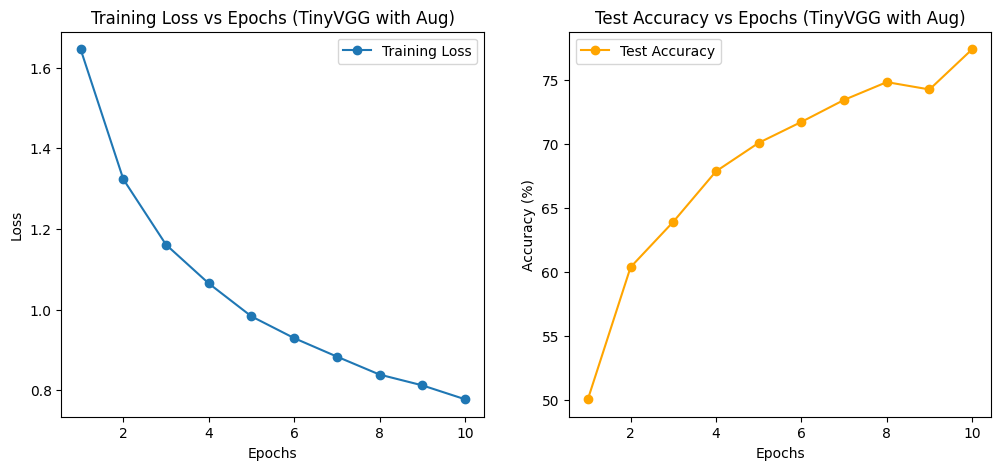

In [7]:
# With Augmentation Training And Testing

model_aug = TinyVGG(input_channel=3, hidden_units=32, output_classes=10)

loss_fn = nn.CrossEntropyLoss()
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = "cuda"
    print("Using Device:", device)
else:
    device = "cpu"
    print("Using Device:", device)

model_aug = model_aug.to(device)

epoch = 10

train_losses = []
test_accuracies = []

for i in range(epoch):
    # Training phase 
    model_aug.train()
    running_loss = 0

    for images, labels in train_dataloader_with_aug:
        images, labels = images.to(device), labels.to(device)

        output = model_aug(images)
        loss = loss_fn(output, labels)

        optimizer_aug.zero_grad()
        loss.backward()
        optimizer_aug.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_dataloader_with_aug)
    train_losses.append(avg_loss)

    # Evaluation phase
    model_aug.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader_noaug:
            images, labels = images.to(device), labels.to(device)
            output = model_aug(images)
            _, predicted_index = torch.max(output, 1)

            total += labels.size(0)
            correct += (predicted_index == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {i+1}/{epoch} Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Plot curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Plot training loss
plt.subplot(1,2,1)
plt.plot(range(1, epoch+1), train_losses, marker='o', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs (TinyVGG with Aug)")
plt.legend()

# Plot test accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epoch+1), test_accuracies, marker='o', color="orange", label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs Epochs (TinyVGG with Aug)")
plt.legend()

plt.show()


In [8]:
import torchvision.models as tv_model

model_resnet  = tv_model.resnet18( weights = "IMAGENET1K_V1")

model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)


Using Device: cuda
Epoch 1/10 Loss: 0.1239 | Test Accuracy: 57.62%
Epoch 2/10 Loss: 0.0927 | Test Accuracy: 48.17%
Epoch 3/10 Loss: 0.1096 | Test Accuracy: 41.24%
Epoch 4/10 Loss: 0.0682 | Test Accuracy: 56.11%
Epoch 5/10 Loss: 0.0620 | Test Accuracy: 48.59%
Epoch 6/10 Loss: 0.0696 | Test Accuracy: 45.23%
Epoch 7/10 Loss: 0.0570 | Test Accuracy: 54.66%
Epoch 8/10 Loss: 0.0451 | Test Accuracy: 62.53%
Epoch 9/10 Loss: 0.0502 | Test Accuracy: 53.45%
Epoch 10/10 Loss: 0.0506 | Test Accuracy: 50.80%


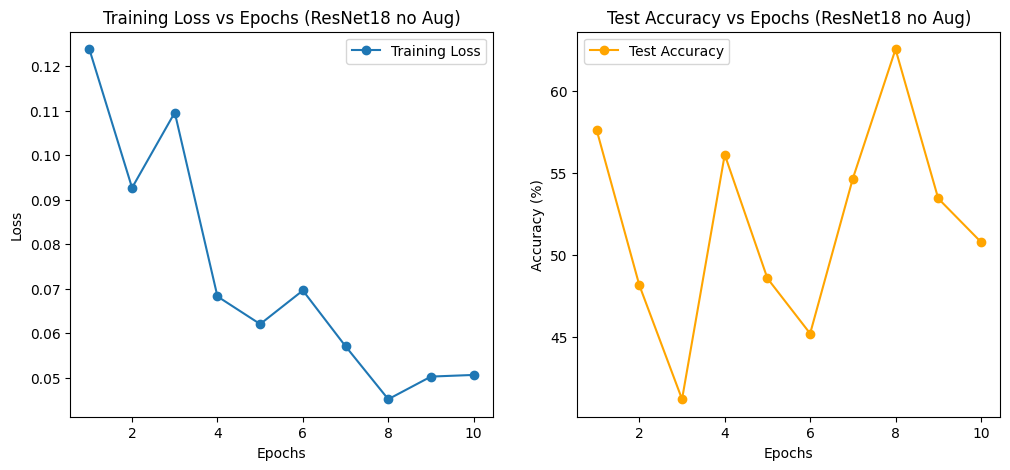

In [13]:
# Training ResNet18 without augmentation

loss_fn_resnet = nn.CrossEntropyLoss()
optimizer_resnet_no_aug = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = "cuda"
    print("Using Device:", device)
else:
    device = "cpu"
    print("Using Device:", device)

model_resnet = model_resnet.to(device)

epoch = 10

train_losses = []
test_accuracies = []

for i in range(epoch):
    # Training phase
    model_resnet.train()
    running_loss = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        output = model_resnet(images)
        loss = loss_fn_resnet(output, labels)

        optimizer_resnet_no_aug.zero_grad()
        loss.backward()
        optimizer_resnet_no_aug.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # Evaluation phase
    model_resnet.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader_noaug:
            images, labels = images.to(device), labels.to(device)
            output = model_resnet(images)
            _, predicted_index = torch.max(output, 1)

            total += labels.size(0)
            correct += (predicted_index == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {i+1}/{epoch} Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Plot curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Plot training loss
plt.subplot(1,2,1)
plt.plot(range(1, epoch+1), train_losses, marker='o', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs (ResNet18 no Aug)")
plt.legend()

# Plot test accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epoch+1), test_accuracies, marker='o', color="orange", label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs Epochs (ResNet18 no Aug)")
plt.legend()

plt.show()


Using Device: cuda
Epoch 1/10 Loss: 1.2151 | Test Accuracy: 66.09%
Epoch 2/10 Loss: 0.9183 | Test Accuracy: 75.17%
Epoch 3/10 Loss: 0.8343 | Test Accuracy: 76.68%
Epoch 4/10 Loss: 0.7699 | Test Accuracy: 78.76%
Epoch 5/10 Loss: 0.7190 | Test Accuracy: 79.36%
Epoch 6/10 Loss: 0.6852 | Test Accuracy: 80.64%
Epoch 7/10 Loss: 0.6523 | Test Accuracy: 82.80%
Epoch 8/10 Loss: 0.6282 | Test Accuracy: 83.46%
Epoch 9/10 Loss: 0.5997 | Test Accuracy: 79.21%
Epoch 10/10 Loss: 0.6029 | Test Accuracy: 84.17%


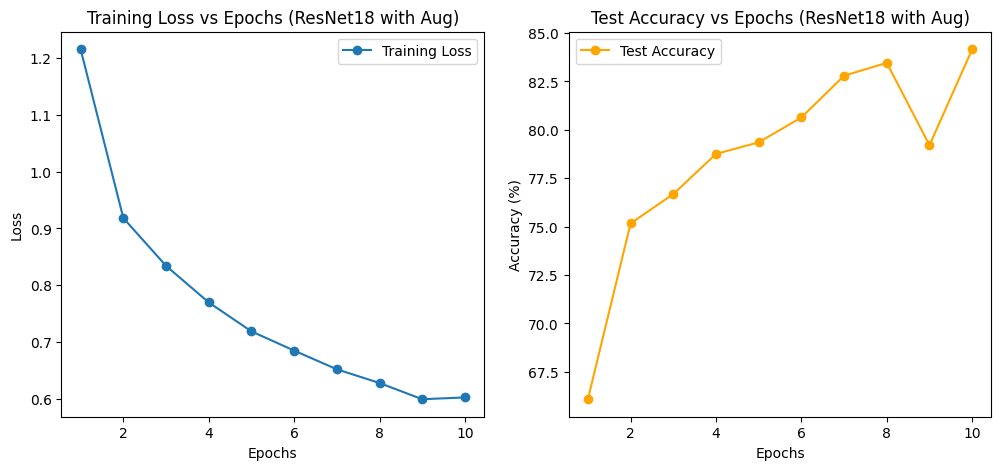

In [10]:
# Training ResNet18 WITH augmentation


model_resnet_aug = tv_model.resnet18(weights="IMAGENET1K_V1")
model_resnet_aug.fc = nn.Linear(model_resnet_aug.fc.in_features, 10)

loss_fn_resnet = nn.CrossEntropyLoss()
optimizer_resnet_with_aug = torch.optim.Adam(model_resnet_aug.parameters(), lr=0.001)

if torch.cuda.is_available():
    device = "cuda"
    print("Using Device:", device)
else:
    device = "cpu"
    print("Using Device:", device)

model_resnet_aug = model_resnet_aug.to(device)

epoch = 10
train_losses = []
test_accuracies = []

for i in range(epoch):
    # Training phase
    model_resnet_aug.train()
    running_loss = 0

    for images, labels in train_dataloader_with_aug:
        images, labels = images.to(device), labels.to(device)

        output = model_resnet_aug(images)
        loss = loss_fn_resnet(output, labels)

        optimizer_resnet_with_aug.zero_grad()
        loss.backward()
        optimizer_resnet_with_aug.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_dataloader_with_aug)
    train_losses.append(avg_loss)

    # Evaluation phase
    model_resnet_aug.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader_noaug:
            images, labels = images.to(device), labels.to(device)
            output = model_resnet_aug(images)
            _, predicted_index = torch.max(output, 1)

            total += labels.size(0)
            correct += (predicted_index == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {i+1}/{epoch} Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Plot curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Plot training loss
plt.subplot(1,2,1)
plt.plot(range(1, epoch+1), train_losses, marker='o', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs (ResNet18 with Aug)")
plt.legend()

# Plot test accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epoch+1), test_accuracies, marker='o', color="orange", label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs Epochs (ResNet18 with Aug)")
plt.legend()

plt.show()


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CIFAR-10 class names
classes = [
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]

def evaluate_model(model, test_loader, loss_fn, device, title="Model"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"{title} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    return avg_loss, accuracy


TinyVGG (no aug) - Loss: 1.7704, Accuracy: 65.20%


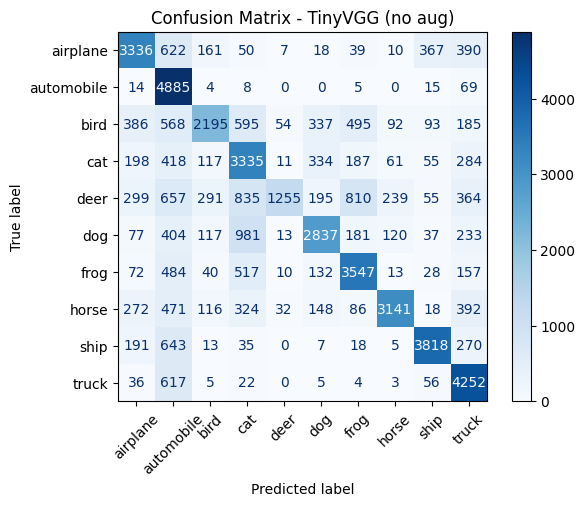

TinyVGG (with aug) - Loss: 0.6457, Accuracy: 77.38%


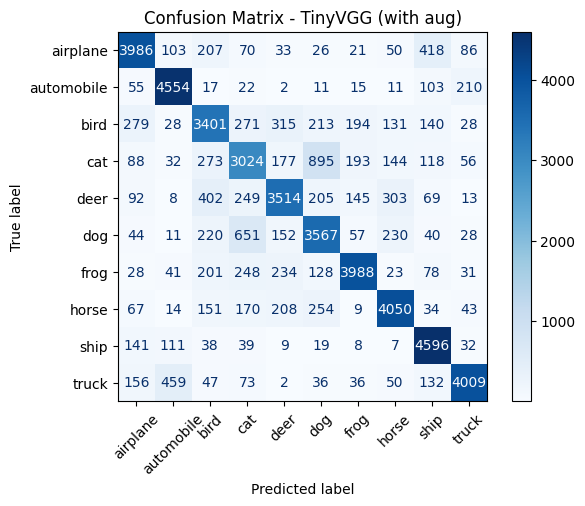

ResNet18 (no aug) - Loss: 3.1398, Accuracy: 41.70%


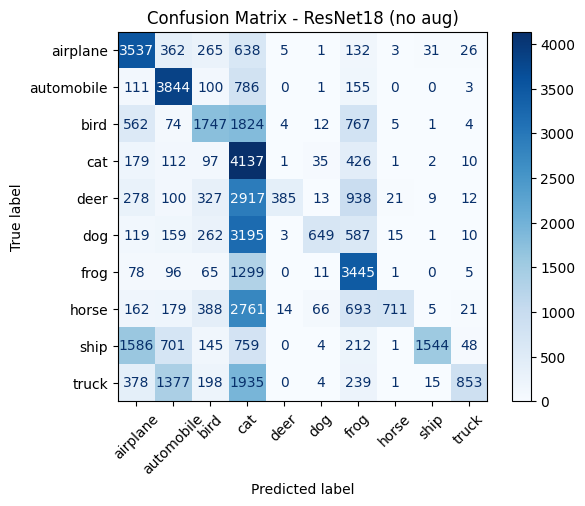

ResNet18 (with aug) - Loss: 0.4590, Accuracy: 84.17%


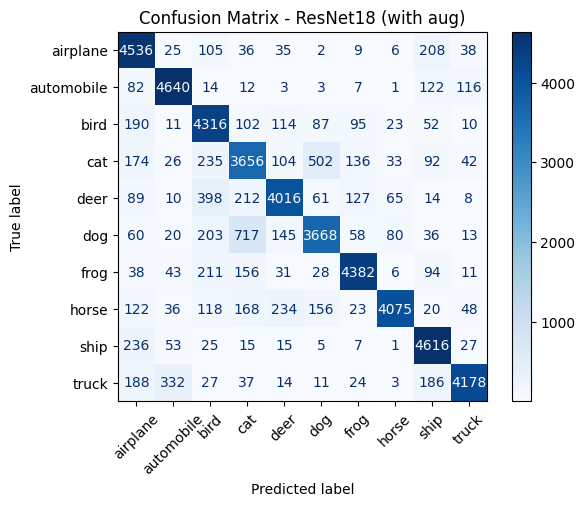

(0.45903732336085773, 84.166)

In [12]:
evaluate_model(model, test_dataloader_noaug, loss_fn, device, title="TinyVGG (no aug)")
evaluate_model(model_aug, test_dataloader_noaug, loss_fn, device, title="TinyVGG (with aug)")
evaluate_model(model_resnet, test_dataloader_noaug, loss_fn_resnet, device, title="ResNet18 (no aug)")
evaluate_model(model_resnet_aug, test_dataloader_noaug, loss_fn_resnet, device, title="ResNet18 (with aug)")